In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


.. currentmodule:: dgl

Graph Classification Tutorial
=============================

**Author**: `Mufei Li <https://github.com/mufeili>`_,
`Minjie Wang <https://jermainewang.github.io/>`_,
`Zheng Zhang <https://shanghai.nyu.edu/academics/faculty/directory/zheng-zhang>`_.

In this tutorial, you learn how to use DGL to batch multiple graphs of variable size and shape. The 
tutorial also demonstrates training a graph neural network for a simple graph classification task.

Graph classification is an important problem
with applications across many fields, such as bioinformatics, chemoinformatics, social
network analysis, urban computing, and cybersecurity. Applying graph neural
networks to this problem has been a popular approach recently. This can be seen in the following reserach references: 
`Ying et al., 2018 <https://arxiv.org/abs/1806.08804>`_,
`Cangea et al., 2018 <https://arxiv.org/abs/1811.01287>`_,
`Knyazev et al., 2018 <https://arxiv.org/abs/1811.09595>`_,
`Bianchi et al., 2019 <https://arxiv.org/abs/1901.01343>`_,
`Liao et al., 2019 <https://arxiv.org/abs/1901.01484>`_,
`Gao et al., 2019 <https://openreview.net/forum?id=HJePRoAct7>`_).


Simple graph classification task
--------------------------------
In this tutorial, you learn how to perform batched graph classification
with DGL. The example task objective is to classify eight types of topologies shown here.

![](https://data.dgl.ai/tutorial/batch/dataset_overview.png)

    :align: center

Implement a synthetic dataset :class:`data.MiniGCDataset` in DGL. The dataset has eight 
different types of graphs and each class has the same number of graph samples.



Using backend: pytorch


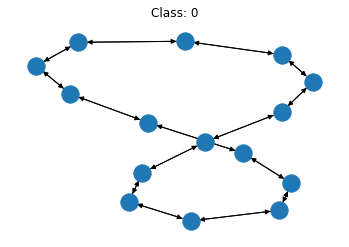

In [2]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
# A dataset with 80 samples, each graph is
# of size [10, 20]
dataset = MiniGCDataset(80, 10, 20)
graph, label = dataset[0]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

Form a graph mini-batch
-----------------------
To train neural networks efficiently, a common practice is to batch
multiple samples together to form a mini-batch. Batching fixed-shaped tensor
inputs is common. For example, batching two images of size 28 x 28
gives a tensor of shape 2 x 28 x 28. By contrast, batching graph inputs
has two challenges:

* Graphs are sparse.
* Graphs can have various length. For example, number of nodes and edges.

To address this, DGL provides a :func:`dgl.batch` API. It leverages the idea that
a batch of graphs can be viewed as a large graph that has many disjointed 
connected components. Below is a visualization that gives the general idea.

![](https://data.dgl.ai/tutorial/batch/batch.png)

    :width: 400pt
    :align: center

Define the following ``collate`` function to form a mini-batch from a given
list of graph and label pairs.



In [3]:
import dgl
import torch

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

The return type of :func:`dgl.batch` is still a graph. In the same way, 
a batch of tensors is still a tensor. This means that any code that works
for one graph immediately works for a batch of graphs. More importantly,
because DGL processes messages on all nodes and edges in parallel, this greatly
improves efficiency.

Graph classifier
----------------
Graph classification proceeds as follows.

![](https://data.dgl.ai/tutorial/batch/graph_classifier.png)


From a batch of graphs, perform message passing and graph convolution
for nodes to communicate with others. After message passing, compute a
tensor for graph representation from node (and edge) attributes. This step might 
be called readout or aggregation. Finally, the graph 
representations are fed into a classifier $g$ to predict the graph labels.

Graph convolution layer can be found in the ``dgl.nn.<backend>`` submodule.



In [4]:
from dgl.nn.pytorch import GraphConv

Readout and classification
--------------------------
For this demonstration, consider initial node features to be their degrees.
After two rounds of graph convolution, perform a graph readout by averaging
over all node features for each graph in the batch.

\begin{align}h_g=\frac{1}{|\mathcal{V}|}\sum_{v\in\mathcal{V}}h_{v}\end{align}

In DGL, :func:`dgl.mean_nodes` handles this task for a batch of
graphs with variable size. You then feed the graph representations into a
classifier with one linear layer to obtain pre-softmax logits.



In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

Setup and training
------------------
Create a synthetic dataset of $400$ graphs with $10$ ~
$20$ nodes. $320$ graphs constitute a training set and
$80$ graphs constitute a test set.



In [6]:
from qplanarity import build_graph
dgl.from_networkx(build_graph([[0, 1], [2, 3]]))

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Graph(num_nodes=4, num_edges=4,
      ndata_schemes={}
      edata_schemes={})

In [7]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Create training and test sets.
trainset = MiniGCDataset(320, 10, 20)
testset = MiniGCDataset(80, 10, 20)

In [8]:
from qplanarity import build_graph, generate_graphs, generate_graphs_dgl

trainset = list(zip(*generate_graphs_dgl(range(3, 11), 2 * [50] + 3 * [100] + 3 * [200], generator='binomial', verbose=True)))
testset = list(zip(*generate_graphs_dgl([16], [10])))

0it [00:00, ?it/s]

Generated graphs with   3 nodes are at 100.0% planar in average
Generated graphs with   4 nodes are at 100.0% planar in average
Generated graphs with   5 nodes are at  78.0% planar in average
Generated graphs with   6 nodes are at  65.0% planar in average
Generated graphs with   7 nodes are at  50.0% planar in average
Generated graphs with   8 nodes are at  53.0% planar in average
Generated graphs with   9 nodes are at  51.5% planar in average
Generated graphs with  10 nodes are at  51.5% planar in average
Generated graphs are at  60.5% planar in average


In [9]:
generate_graphs_dgl([10], [1000], generator='uniform_edges', verbose=True)
generate_graphs_dgl([10], [1000], generator='binomial', verbose=True)
0

0it [00:00, ?it/s]

Maximum edge number is 45
Generated graphs with  10 nodes are at  25.0% planar in average
Generated graphs are at  25.0% planar in average


0it [00:00, ?it/s]

Generated graphs with  10 nodes are at  52.2% planar in average
Generated graphs are at  52.2% planar in average


0

In [10]:
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)

# Create model
num_classes = 2
model = Classifier(1, 256, num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 0.6371
Epoch 1, loss 0.5171
Epoch 2, loss 0.2512
Epoch 3, loss 0.1059
Epoch 4, loss 0.0794
Epoch 5, loss 0.0759
Epoch 6, loss 0.0709
Epoch 7, loss 0.0601
Epoch 8, loss 0.0586
Epoch 9, loss 0.0571
Epoch 10, loss 0.0616
Epoch 11, loss 0.0632
Epoch 12, loss 0.0656
Epoch 13, loss 0.0563
Epoch 14, loss 0.0581
Epoch 15, loss 0.0580
Epoch 16, loss 0.0691
Epoch 17, loss 0.0881
Epoch 18, loss 0.0932
Epoch 19, loss 0.0656
Epoch 20, loss 0.0593
Epoch 21, loss 0.0605
Epoch 22, loss 0.0584
Epoch 23, loss 0.0656
Epoch 24, loss 0.0595
Epoch 25, loss 0.0552
Epoch 26, loss 0.0548
Epoch 27, loss 0.0563
Epoch 28, loss 0.0674
Epoch 29, loss 0.0536
Epoch 30, loss 0.0589
Epoch 31, loss 0.0599
Epoch 32, loss 0.0570
Epoch 33, loss 0.0599
Epoch 34, loss 0.0630
Epoch 35, loss 0.0616
Epoch 36, loss 0.0628
Epoch 37, loss 0.0549
Epoch 38, loss 0.0550
Epoch 39, loss 0.0595
Epoch 40, loss 0.0650
Epoch 41, loss 0.0591
Epoch 42, loss 0.0651
Epoch 43, loss 0.0564
Epoch 44, loss 0.0565
Epoch 45, loss 0.068

The learning curve of a run is presented below.



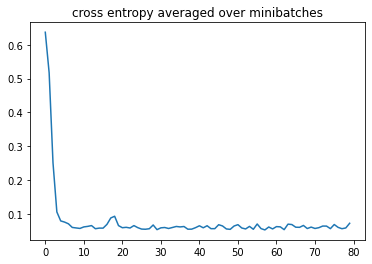

In [11]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

The trained model is evaluated on the test set created. To deploy
the tutorial, restrict the running time to get a higher
accuracy ($80$ % ~ $90$ %) than the ones printed below.



In [12]:
def dgl_tester(model, testset):
    model.eval()
    # Convert a list of tuples to two lists
    test_X, test_Y = map(list, zip(*testset))
    test_bg = dgl.batch(test_X)
    test_Y = torch.tensor(test_Y).float().view(-1, 1)
    probs_Y = torch.softmax(model(test_bg), 1)
    sampled_Y = torch.multinomial(probs_Y, 1)
    argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
    print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
        (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
    argmax_score = (test_Y == argmax_Y.float()).sum().item() / len(test_Y)
    print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
        argmax_score * 100
    ))
    return argmax_Y, test_Y, argmax_score
dgl_tester(model, testset)[2]

Accuracy of sampled predictions on the test set: 100.0000%
Accuracy of argmax predictions on the test set: 100.000000%


1.0

In [13]:
from sklearn.metrics import confusion_matrix

scores = []
ns = range(5, 31)
for n in ns:
    graphs, targets = generate_graphs_dgl([n], [1000], generator='binomial', verbose=True)
    y_pred, y_true, score = dgl_tester(model, zip(graphs, targets))
    print(confusion_matrix(y_true, y_pred))
    print(f"\t### SCORE OF {score} FOR {n} NODES ###\n")
    scores.append(score)

0it [00:00, ?it/s]

Generated graphs with   5 nodes are at  79.1% planar in average
Generated graphs are at  79.1% planar in average
Accuracy of sampled predictions on the test set: 93.5000%
Accuracy of argmax predictions on the test set: 100.000000%
[[209   0]
 [  0 791]]
	### SCORE OF 1.0 FOR 5 NODES ###



0it [00:00, ?it/s]

Generated graphs with   6 nodes are at  67.4% planar in average
Generated graphs are at  67.4% planar in average
Accuracy of sampled predictions on the test set: 98.0000%
Accuracy of argmax predictions on the test set: 100.000000%
[[326   0]
 [  0 674]]
	### SCORE OF 1.0 FOR 6 NODES ###



0it [00:00, ?it/s]

Generated graphs with   7 nodes are at  46.4% planar in average
Generated graphs are at  46.4% planar in average
Accuracy of sampled predictions on the test set: 83.5000%
Accuracy of argmax predictions on the test set: 82.600000%
[[362 174]
 [  0 464]]
	### SCORE OF 0.826 FOR 7 NODES ###



0it [00:00, ?it/s]

Generated graphs with   8 nodes are at  55.8% planar in average
Generated graphs are at  55.8% planar in average
Accuracy of sampled predictions on the test set: 97.3000%
Accuracy of argmax predictions on the test set: 100.000000%
[[442   0]
 [  0 558]]
	### SCORE OF 1.0 FOR 8 NODES ###



0it [00:00, ?it/s]

Generated graphs with   9 nodes are at  52.4% planar in average
Generated graphs are at  52.4% planar in average
Accuracy of sampled predictions on the test set: 96.9000%
Accuracy of argmax predictions on the test set: 100.000000%
[[476   0]
 [  0 524]]
	### SCORE OF 1.0 FOR 9 NODES ###



0it [00:00, ?it/s]

Generated graphs with  10 nodes are at  50.9% planar in average
Generated graphs are at  50.9% planar in average
Accuracy of sampled predictions on the test set: 98.8000%
Accuracy of argmax predictions on the test set: 97.900000%
[[491   0]
 [ 21 488]]
	### SCORE OF 0.979 FOR 10 NODES ###



0it [00:00, ?it/s]

Generated graphs with  11 nodes are at  44.2% planar in average
Generated graphs are at  44.2% planar in average
Accuracy of sampled predictions on the test set: 97.2000%
Accuracy of argmax predictions on the test set: 97.800000%
[[536  22]
 [  0 442]]
	### SCORE OF 0.978 FOR 11 NODES ###



0it [00:00, ?it/s]

Generated graphs with  12 nodes are at  41.7% planar in average
Generated graphs are at  41.7% planar in average
Accuracy of sampled predictions on the test set: 96.6000%
Accuracy of argmax predictions on the test set: 97.700000%
[[560  23]
 [  0 417]]
	### SCORE OF 0.977 FOR 12 NODES ###



0it [00:00, ?it/s]

Generated graphs with  13 nodes are at  36.6% planar in average
Generated graphs are at  36.6% planar in average
Accuracy of sampled predictions on the test set: 96.2000%
Accuracy of argmax predictions on the test set: 96.100000%
[[595  39]
 [  0 366]]
	### SCORE OF 0.961 FOR 13 NODES ###



0it [00:00, ?it/s]

Generated graphs with  14 nodes are at  29.4% planar in average
Generated graphs are at  29.4% planar in average
Accuracy of sampled predictions on the test set: 88.3000%
Accuracy of argmax predictions on the test set: 88.400000%
[[590 116]
 [  0 294]]
	### SCORE OF 0.884 FOR 14 NODES ###



0it [00:00, ?it/s]

Generated graphs with  15 nodes are at  29.4% planar in average
Generated graphs are at  29.4% planar in average
Accuracy of sampled predictions on the test set: 93.7000%
Accuracy of argmax predictions on the test set: 97.400000%
[[680  26]
 [  0 294]]
	### SCORE OF 0.974 FOR 15 NODES ###



0it [00:00, ?it/s]

Generated graphs with  16 nodes are at  26.8% planar in average
Generated graphs are at  26.8% planar in average
Accuracy of sampled predictions on the test set: 91.5000%
Accuracy of argmax predictions on the test set: 92.900000%
[[661  71]
 [  0 268]]
	### SCORE OF 0.929 FOR 16 NODES ###



0it [00:00, ?it/s]

Generated graphs with  17 nodes are at  20.7% planar in average
Generated graphs are at  20.7% planar in average
Accuracy of sampled predictions on the test set: 95.4000%
Accuracy of argmax predictions on the test set: 97.000000%
[[763  30]
 [  0 207]]
	### SCORE OF 0.97 FOR 17 NODES ###



0it [00:00, ?it/s]

Generated graphs with  18 nodes are at  18.9% planar in average
Generated graphs are at  18.9% planar in average
Accuracy of sampled predictions on the test set: 97.8000%
Accuracy of argmax predictions on the test set: 96.700000%
[[778  33]
 [  0 189]]
	### SCORE OF 0.967 FOR 18 NODES ###



0it [00:00, ?it/s]

Generated graphs with  19 nodes are at  19.2% planar in average
Generated graphs are at  19.2% planar in average
Accuracy of sampled predictions on the test set: 97.2000%
Accuracy of argmax predictions on the test set: 97.400000%
[[782  26]
 [  0 192]]
	### SCORE OF 0.974 FOR 19 NODES ###



0it [00:00, ?it/s]

Generated graphs with  20 nodes are at  20.9% planar in average
Generated graphs are at  20.9% planar in average
Accuracy of sampled predictions on the test set: 97.9000%
Accuracy of argmax predictions on the test set: 100.000000%
[[791   0]
 [  0 209]]
	### SCORE OF 1.0 FOR 20 NODES ###



0it [00:00, ?it/s]

Generated graphs with  21 nodes are at  15.9% planar in average
Generated graphs are at  15.9% planar in average
Accuracy of sampled predictions on the test set: 94.2000%
Accuracy of argmax predictions on the test set: 93.700000%
[[778  63]
 [  0 159]]
	### SCORE OF 0.937 FOR 21 NODES ###



0it [00:00, ?it/s]

Generated graphs with  22 nodes are at  11.6% planar in average
Generated graphs are at  11.6% planar in average
Accuracy of sampled predictions on the test set: 94.4000%
Accuracy of argmax predictions on the test set: 94.100000%
[[825  59]
 [  0 116]]
	### SCORE OF 0.941 FOR 22 NODES ###



0it [00:00, ?it/s]

Generated graphs with  23 nodes are at  11.0% planar in average
Generated graphs are at  11.0% planar in average
Accuracy of sampled predictions on the test set: 93.8000%
Accuracy of argmax predictions on the test set: 93.400000%
[[824  66]
 [  0 110]]
	### SCORE OF 0.934 FOR 23 NODES ###



0it [00:00, ?it/s]

Generated graphs with  24 nodes are at   9.5% planar in average
Generated graphs are at   9.5% planar in average
Accuracy of sampled predictions on the test set: 93.0000%
Accuracy of argmax predictions on the test set: 92.200000%
[[827  78]
 [  0  95]]
	### SCORE OF 0.922 FOR 24 NODES ###



0it [00:00, ?it/s]

Generated graphs with  25 nodes are at   7.3% planar in average
Generated graphs are at   7.3% planar in average
Accuracy of sampled predictions on the test set: 94.8000%
Accuracy of argmax predictions on the test set: 94.000000%
[[867  60]
 [  0  73]]
	### SCORE OF 0.94 FOR 25 NODES ###



0it [00:00, ?it/s]

Generated graphs with  26 nodes are at   9.8% planar in average
Generated graphs are at   9.8% planar in average
Accuracy of sampled predictions on the test set: 94.7000%
Accuracy of argmax predictions on the test set: 94.600000%
[[848  54]
 [  0  98]]
	### SCORE OF 0.946 FOR 26 NODES ###



0it [00:00, ?it/s]

Generated graphs with  27 nodes are at   6.6% planar in average
Generated graphs are at   6.6% planar in average
Accuracy of sampled predictions on the test set: 93.8000%
Accuracy of argmax predictions on the test set: 92.800000%
[[862  72]
 [  0  66]]
	### SCORE OF 0.928 FOR 27 NODES ###



0it [00:00, ?it/s]

Generated graphs with  28 nodes are at   8.0% planar in average
Generated graphs are at   8.0% planar in average
Accuracy of sampled predictions on the test set: 96.8000%
Accuracy of argmax predictions on the test set: 96.400000%
[[884  36]
 [  0  80]]
	### SCORE OF 0.964 FOR 28 NODES ###



0it [00:00, ?it/s]

Generated graphs with  29 nodes are at   6.3% planar in average
Generated graphs are at   6.3% planar in average
Accuracy of sampled predictions on the test set: 93.1000%
Accuracy of argmax predictions on the test set: 93.800000%
[[875  62]
 [  0  63]]
	### SCORE OF 0.938 FOR 29 NODES ###



0it [00:00, ?it/s]

Generated graphs with  30 nodes are at   6.6% planar in average
Generated graphs are at   6.6% planar in average
Accuracy of sampled predictions on the test set: 93.6000%
Accuracy of argmax predictions on the test set: 95.300000%
[[887  47]
 [  0  66]]
	### SCORE OF 0.953 FOR 30 NODES ###



Text(0.5, 0, 'Number of nodes')

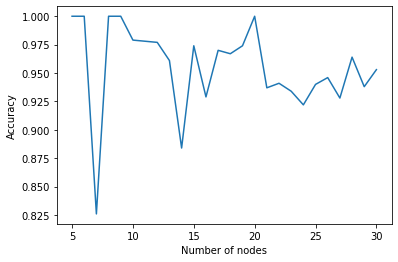

In [14]:
plt.plot(ns, scores)
plt.ylabel('Accuracy')
plt.xlabel('Number of nodes')

The animation here plots the probability that a trained model predicts the correct graph type.

![](https://data.dgl.ai/tutorial/batch/test_eval4.gif)


To understand the node and graph representations that a trained model learned,
we use `t-SNE, <https://lvdmaaten.github.io/tsne/>`_ for dimensionality reduction
and visualization.

![](https://data.dgl.ai/tutorial/batch/tsne_node2.png)

    :align: center

![](https://data.dgl.ai/tutorial/batch/tsne_graph2.png)

    :align: center

The two small figures on the top separately visualize node representations after one and two
layers of graph convolution. The figure on the bottom visualizes
the pre-softmax logits for graphs as graph representations.

While the visualization does suggest some clustering effects of the node features,
you would not expect a perfect result. Node degrees are deterministic for
these node features. The graph features are improved when separated.

What's next?
------------
Graph classification with graph neural networks is still a new field.
It's waiting for people to bring more exciting discoveries. The work requires 
mapping different graphs to different embeddings, while preserving
their structural similarity in the embedding space. To learn more about it, see 
`How Powerful Are Graph Neural Networks? <https://arxiv.org/abs/1810.00826>`_ a research paper  
published for the International Conference on Learning Representations 2019.

For more examples about batched graph processing, see the following:

* Tutorials for `Tree LSTM <https://docs.dgl.ai/tutorials/models/2_small_graph/3_tree-lstm.html>`_ and `Deep Generative Models of Graphs <https://docs.dgl.ai/tutorials/models/3_generative_model/5_dgmg.html>`_
* An example implementation of `Junction Tree VAE <https://github.com/dmlc/dgl/tree/master/examples/pytorch/jtnn>`_




	# 1. Generate train and test datasets



0it [00:00, ?it/s]

Generated graphs with   3 nodes are at 100.0% planar in average
Generated graphs with   4 nodes are at 100.0% planar in average
Generated graphs with   5 nodes are at  72.0% planar in average
Generated graphs with   6 nodes are at  64.0% planar in average
Generated graphs with   7 nodes are at  50.0% planar in average
Generated graphs with   8 nodes are at  64.0% planar in average
Generated graphs with   9 nodes are at  53.5% planar in average
Generated graphs with  10 nodes are at  46.5% planar in average
Generated graphs are at  61.4% planar in average

	# 2. Train model

Epoch 0, loss 0.6221
Epoch 1, loss 0.4724
Epoch 2, loss 0.2358
Epoch 3, loss 0.1172
Epoch 4, loss 0.0906
Epoch 5, loss 0.0816
Epoch 6, loss 0.0895
Epoch 7, loss 0.0713
Epoch 8, loss 0.0712
Epoch 9, loss 0.0732
Epoch 10, loss 0.0709
Epoch 11, loss 0.0656
Epoch 12, loss 0.0702
Epoch 13, loss 0.0751
Epoch 14, loss 0.0722
Epoch 15, loss 0.0709
Epoch 16, loss 0.0708
Epoch 17, loss 0.0720
Epoch 18, loss 0.0740
Epoch 19, l

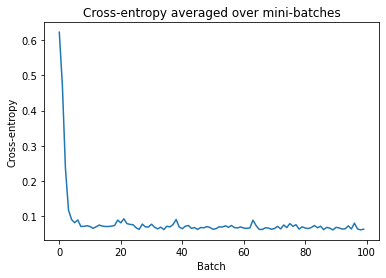

Classifier(
  (conv1): GraphConv(in=1, out=256, normalization=both, activation=None)
  (conv2): GraphConv(in=256, out=256, normalization=both, activation=None)
  (classify): Linear(in_features=256, out_features=2, bias=True)
)

	# 3. Smoke-test model

Accuracy of sampled predictions on the test set: 94.9000%
Accuracy of argmax predictions on the test set: 97.700000%
[[368  18]
 [  5 609]]
              precision    recall  f1-score   support

  Non-planar       0.99      0.95      0.97       386
      Planar       0.97      0.99      0.98       614

    accuracy                           0.98      1000
   macro avg       0.98      0.97      0.98      1000
weighted avg       0.98      0.98      0.98      1000


	### Score: 97.70% (precision for planar: 0.971 & non-planar: 0.987)

	# 4. Investigate generalisation capabilities


	#   a. 10 graphs of 18 nodes

Accuracy of sampled predictions on the test set: 100.0000%
Accuracy of argmax predictions on the test set: 100.000000%
[[8 0]
 [0 2

Accuracy of sampled predictions on the test set: 96.0000%
Accuracy of argmax predictions on the test set: 95.900000%
[[758   0]
 [ 41 201]]
              precision    recall  f1-score   support

  Non-planar       0.95      1.00      0.97       758
      Planar       1.00      0.83      0.91       242

    accuracy                           0.96      1000
   macro avg       0.97      0.92      0.94      1000
weighted avg       0.96      0.96      0.96      1000


	### Score: 95.90% (precision for planar: 1.000 & non-planar: 0.949)

	### 18 NODES ###
Accuracy of sampled predictions on the test set: 95.5000%
Accuracy of argmax predictions on the test set: 96.400000%
[[779   0]
 [ 36 185]]
              precision    recall  f1-score   support

  Non-planar       0.96      1.00      0.98       779
      Planar       1.00      0.84      0.91       221

    accuracy                           0.96      1000
   macro avg       0.98      0.92      0.94      1000
weighted avg       0.97      0.9

Accuracy of sampled predictions on the test set: 95.1000%
Accuracy of argmax predictions on the test set: 95.200000%
[[884   0]
 [ 48  68]]
              precision    recall  f1-score   support

  Non-planar       0.95      1.00      0.97       884
      Planar       1.00      0.59      0.74       116

    accuracy                           0.95      1000
   macro avg       0.97      0.79      0.86      1000
weighted avg       0.95      0.95      0.95      1000


	### Score: 95.20% (precision for planar: 1.000 & non-planar: 0.948)

	### 33 NODES ###
Accuracy of sampled predictions on the test set: 97.1000%
Accuracy of argmax predictions on the test set: 97.400000%
[[908   0]
 [ 26  66]]
              precision    recall  f1-score   support

  Non-planar       0.97      1.00      0.99       908
      Planar       1.00      0.72      0.84        92

    accuracy                           0.97      1000
   macro avg       0.99      0.86      0.91      1000
weighted avg       0.97      0.9

Accuracy of sampled predictions on the test set: 98.3000%
Accuracy of argmax predictions on the test set: 98.300000%
[[952   0]
 [ 17  31]]
              precision    recall  f1-score   support

  Non-planar       0.98      1.00      0.99       952
      Planar       1.00      0.65      0.78        48

    accuracy                           0.98      1000
   macro avg       0.99      0.82      0.89      1000
weighted avg       0.98      0.98      0.98      1000


	### Score: 98.30% (precision for planar: 1.000 & non-planar: 0.982)

	### 48 NODES ###
Accuracy of sampled predictions on the test set: 97.8000%
Accuracy of argmax predictions on the test set: 97.700000%
[[938   0]
 [ 23  39]]
              precision    recall  f1-score   support

  Non-planar       0.98      1.00      0.99       938
      Planar       1.00      0.63      0.77        62

    accuracy                           0.98      1000
   macro avg       0.99      0.81      0.88      1000
weighted avg       0.98      0.9

Accuracy of sampled predictions on the test set: 98.3000%
Accuracy of argmax predictions on the test set: 98.300000%
[[958   0]
 [ 17  25]]
              precision    recall  f1-score   support

  Non-planar       0.98      1.00      0.99       958
      Planar       1.00      0.60      0.75        42

    accuracy                           0.98      1000
   macro avg       0.99      0.80      0.87      1000
weighted avg       0.98      0.98      0.98      1000


	### Score: 98.30% (precision for planar: 1.000 & non-planar: 0.983)

	### 63 NODES ###
Accuracy of sampled predictions on the test set: 98.2000%
Accuracy of argmax predictions on the test set: 98.400000%
[[957   0]
 [ 16  27]]
              precision    recall  f1-score   support

  Non-planar       0.98      1.00      0.99       957
      Planar       1.00      0.63      0.77        43

    accuracy                           0.98      1000
   macro avg       0.99      0.81      0.88      1000
weighted avg       0.98      0.9

Accuracy of sampled predictions on the test set: 99.3000%
Accuracy of argmax predictions on the test set: 99.100000%
[[965   0]
 [  9  26]]
              precision    recall  f1-score   support

  Non-planar       0.99      1.00      1.00       965
      Planar       1.00      0.74      0.85        35

    accuracy                           0.99      1000
   macro avg       1.00      0.87      0.92      1000
weighted avg       0.99      0.99      0.99      1000


	### Score: 99.10% (precision for planar: 1.000 & non-planar: 0.991)

	### 78 NODES ###
Accuracy of sampled predictions on the test set: 98.4000%
Accuracy of argmax predictions on the test set: 98.500000%
[[958   0]
 [ 15  27]]
              precision    recall  f1-score   support

  Non-planar       0.98      1.00      0.99       958
      Planar       1.00      0.64      0.78        42

    accuracy                           0.98      1000
   macro avg       0.99      0.82      0.89      1000
weighted avg       0.99      0.9

Accuracy of sampled predictions on the test set: 98.5000%
Accuracy of argmax predictions on the test set: 98.600000%
[[961   0]
 [ 14  25]]
              precision    recall  f1-score   support

  Non-planar       0.99      1.00      0.99       961
      Planar       1.00      0.64      0.78        39

    accuracy                           0.99      1000
   macro avg       0.99      0.82      0.89      1000
weighted avg       0.99      0.99      0.98      1000


	### Score: 98.60% (precision for planar: 1.000 & non-planar: 0.986)

	### 93 NODES ###
Accuracy of sampled predictions on the test set: 98.7000%
Accuracy of argmax predictions on the test set: 98.700000%
[[970   0]
 [ 13  17]]
              precision    recall  f1-score   support

  Non-planar       0.99      1.00      0.99       970
      Planar       1.00      0.57      0.72        30

    accuracy                           0.99      1000
   macro avg       0.99      0.78      0.86      1000
weighted avg       0.99      0.9

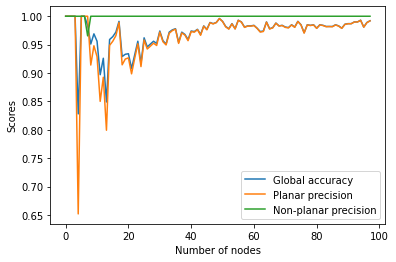

[(1.0, 1, 1),
 (1.0, 1, 1),
 (1.0, 1.0, 1.0),
 (1.0, 1.0, 1.0),
 (0.828, 0.6518218623481782, 1.0),
 (1.0, 1.0, 1.0),
 (1.0, 1.0, 1.0),
 (0.984, 1.0, 0.9654427645788337),
 (0.951, 0.9140350877192982, 1.0),
 (0.969, 0.947986577181208, 1.0),
 (0.956, 0.9288025889967637, 1.0),
 (0.897, 0.8500727802037845, 1.0),
 (0.926, 0.8925979680696662, 1.0),
 (0.849, 0.7992021276595744, 1.0),
 (0.959, 0.9486858573216521, 1.0),
 (0.964, 0.9558282208588957, 1.0),
 (0.972, 0.9657282741738066, 1.0),
 (0.991, 0.989010989010989, 1.0),
 (0.929, 0.9144578313253012, 1.0),
 (0.933, 0.9246344206974129, 1.0),
 (0.934, 0.9266666666666666, 1.0),
 (0.908, 0.898566703417861, 1.0),
 (0.932, 0.925845147219193, 1.0),
 (0.956, 0.9515418502202643, 1.0),
 (0.917, 0.9113247863247863, 1.0),
 (0.962, 0.958103638368247, 1.0),
 (0.946, 0.9423076923076923, 1.0),
 (0.951, 0.9473118279569892, 1.0),
 (0.956, 0.9525350593311759, 1.0),
 (0.952, 0.9484978540772532, 1.0),
 (0.974, 0.9721627408993576, 1.0),
 (0.957, 0.9551148225469729, 1

In [15]:
from qplanarity import test_suite_dgl

train_ns = range(3, 11)
train_nbs = 2 * [50] + 3 * [100] + 3 * [200]
generator = 'binomial'

test_suite_dgl(train_ns, train_nbs, generator, seed=21)

In [58]:
# Test how planarity scales
from qplanarity import generate_graphs
from tqdm.auto import tqdm, trange
import planarity
import time
import matplotlib.pyplot as plt
import numpy as np

In [59]:
# Investigate time taken for planar vs non-planar

In [67]:
N = 1000
ns = range(3, 201)

ratio_planars = []
times = []
times_p = []
times_np = []
for n in tqdm(ns):
    graphs, targets = generate_graphs([n], [N])
    ratio_planars.append(sum(targets) / N)
    print(ratio_planars[-1])
    graphs = list(map(lambda g: list(g.edges), graphs))
    times_p_loop, times_np_loop = [], []
    for i in range(N):
        start = time.time()
        assert targets[i] == planarity.is_planar(graphs[i]), f"{graphs[i]} gives {planarity.is_planar(graphs[i])} vs {targets[i]}"
        end = time.time()
        if targets[i]:
            times_p_loop.append(end - start)
        else:
            times_np_loop.append(end - start)
    times_p.append(times_p_loop)
    times_np.append(times_np_loop)
    times.append((sum(times_p_loop) + sum(times_np_loop)) / N)

  0%|          | 0/198 [00:00<?, ?it/s]

1.0
1.0
0.846
0.662
0.478
0.368
0.297
0.248
0.2
0.137
0.125
0.103
0.089
0.089
0.071
0.054
0.052
0.046
0.036
0.038
0.036
0.034
0.022
0.021
0.028
0.017
0.018
0.019
0.017
0.018
0.014
0.014
0.009
0.017
0.006
0.007
0.007
0.006
0.008
0.002
0.006
0.003
0.001
0.006
0.004
0.003
0.007
0.002
0.005
0.0
0.001
0.003
0.002
0.004
0.003
0.0
0.001
0.003
0.0
0.0
0.002
0.0
0.001
0.001
0.001
0.001
0.002
0.0
0.001
0.001
0.0
0.0
0.0
0.0
0.0
0.0
0.001
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.001
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [91]:
real_ns = ns[:len(times)]  # if stopped computation

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
def func(x, a, b, c, d):
    return a + b * x + c * x * x + d * x * x * x

popt, pcov = curve_fit(func, real_ns, times, bounds=(0, [3., 1., 0.5, 1.]))
popt

array([9.08289674e-32, 2.12092898e-12, 6.50328036e-08, 9.59762675e-12])

<IPython.core.display.Javascript object>


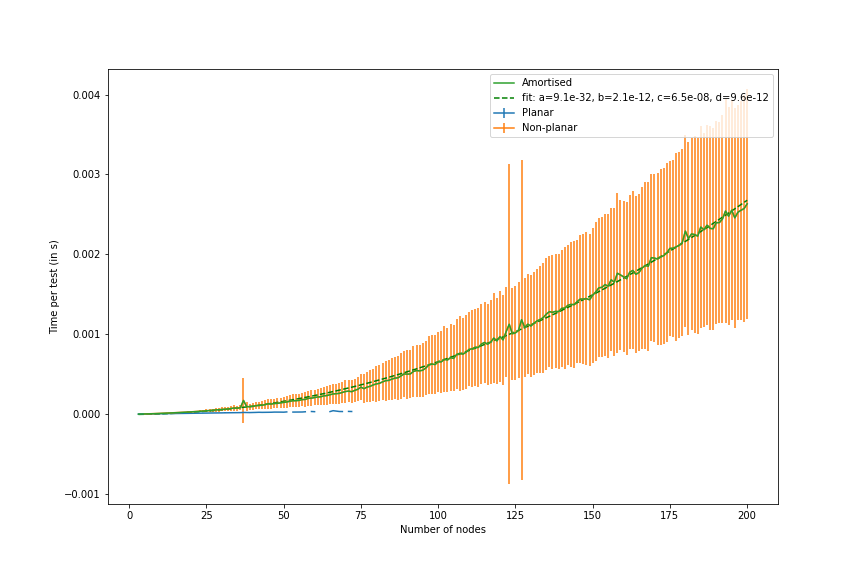

/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/romainfouilland/.pyenv/versions/3.8.3/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret =

In [93]:
%matplotlib notebook

plt.figure(figsize=(12, 8))
plt.errorbar(
    real_ns,
    list(map(np.mean, times_p)),
    list(map(np.std, times_p)),
    label='Planar'
)
plt.errorbar(
    real_ns,
    list(map(np.mean, times_np)),
    list(map(lambda l: min(0.002, np.std(l)), times_np)),
    label='Non-planar'
)
plt.plot(real_ns, np.array(times), label='Amortised', zorder=10)
plt.plot(real_ns, func(real_ns, *popt), 'g--',
         label='fit: a=%.1e, b=%.1e, c=%.1e, d=%.1e' % tuple(popt))
plt.legend()
plt.ylabel('Time per test (in s)')
plt.xlabel('Number of nodes')
plt.show()